In [34]:
import numpy as np

def generate_atoms_in_sphere(density, num_atoms, atom_name="X"):
    """
    Generates atom positions uniformly distributed in a sphere given the density and number of atoms.

    Parameters:
        density (float): Target density in atoms per cubic angstrom (Å^-3).
        num_atoms (int): Number of atoms to generate.
        atom_name (str): Symbol or name of the atom.

    Returns:
        List[str]: Each element is "AtomName\\tX\\tY\\tZ"
    """
    # Calculate volume needed for given density and number of atoms
    volume = num_atoms / density  # in Å^3
    radius = (3 * volume / (4 * np.pi))**(1/3)  # radius of the sphere in Å

    atoms = []
    count = 0
    while count < num_atoms:
        # Generate a random point in a cube [-r, r]³
        point = np.random.uniform(-radius, radius, size=3)
        if np.linalg.norm(point) <= radius:  # keep only points inside the sphere
            atoms.append(f"{atom_name}\t{point[0]:.3f}\t{point[1]:.3f}\t{point[2]:.3f}")
            count += 1

    return atoms


In [37]:
#testing 
atoms_list = generate_atoms_in_sphere(density=0.027, num_atoms=10000, atom_name="He")
for line in atoms_list[:10]:  # print first 10 lines
    print(line)

He	-15.947	5.307	30.966
He	35.789	-6.578	12.263
He	-12.523	-13.217	-24.120
He	11.766	2.035	-11.692
He	28.260	21.351	21.755
He	-12.281	32.498	13.098
He	-18.559	22.370	26.483
He	-17.102	-5.065	11.062
He	4.488	1.595	-8.122
He	-30.316	20.030	-7.875


In [38]:
def save_atoms_to_xyz(filename, atoms):
    """
    Save a list of atom positions to an .xyz file.

    Parameters:
        filename (str): Output file name.
        atoms (List[str]): Atom position lines like "AtomName\\tX\\tY\\tZ".
    """
    with open(filename, 'w') as f:
        f.write(f"{len(atoms)}\n")
        for line in atoms:
            f.write(line.replace("\t", " ") + "\n")

In [39]:
save_atoms_to_xyz("HE10e4_0p027", atoms_list)

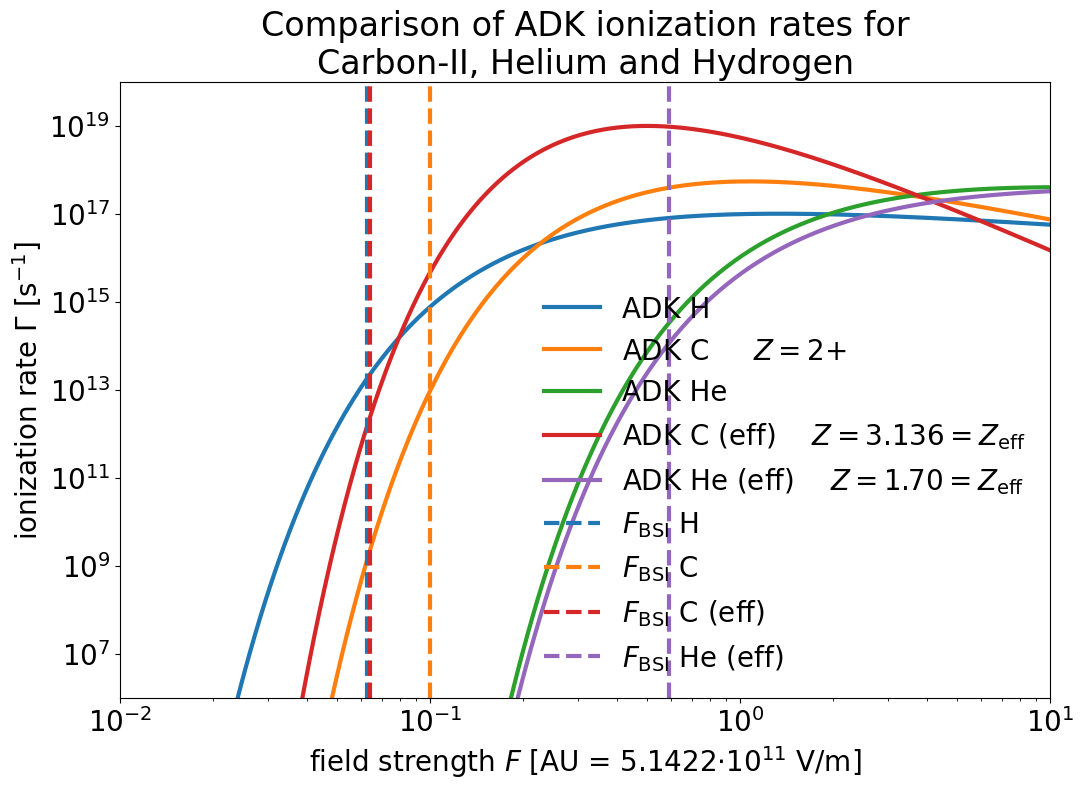

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np


params = {
    'font.size': 20,
    'lines.linewidth': 3,
    'legend.fontsize': 20,
    'legend.frameon': False,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    # RTD default textwidth: 800px
    'figure.figsize': [12, 8]
}
mpl.rcParams.update(params)


def ADK_rate_simple(Z, E_i, F):
    """
    ADK tunneling rate from [DeloneKrainov1998] that has been simplified
    for s-states.

    Args:
        Z   : residual ion charge
        E_i : ionization energy of the state
        F   : electric field strength
    """
    n_eff = Z / ((2.*E_i)**(1./2.))     # effective principal quantum number
    D = ((4.*np.exp(1.)*Z**3.) / (F*n_eff**4.))**n_eff         # some factor

    # laser is circularly polarized
    # pol_fac = 1.
    # laser is lin. polarized
    pol_fac = ((3*n_eff**3*F) / (np.pi*Z**3))**(1.0/2)
    I_rate = pol_fac * (F*D**2.) / (8.*np.pi*Z) * \
        np.exp(-(2.*Z**3.) / (3.*n_eff**3.*F))
    return I_rate


if __name__ == "__main__":
    """
    On execution this file produces the image
    `field_ionization_comparison_c_ii_ionization.svg`
    for the PIConGPU documentation.
    """

    # Atomic units
    E_AU = 27.2  # eV
    F_AU = 5.1422e11  # V/m
    I_AU = 3.5095e16  # W/cm^2
    T_AU = 150.e-18 / (2. * np.pi)

    # Hydrogen
    Z_H = 1.  # proton number
    E_H = .5  # ionization energy (AU)

    # He
    Z_He = 2.
    E_He_SI = np.array([24.58, 54.41])
    E_He = E_He_SI/E_AU

    # Carbon
    Z_C = 6.
    E_C_SI = np.array([11.26, 24.36, 47.89, 64.49, 392.09, 490.00])
    E_C = E_C_SI/E_AU
    
    ymin = 1e6
    ymax = 1e20

    # electric field strengths in AU
    fields = 10**np.linspace(-5, 3, 1000)
    
    #Calculating for Hydrogen
    H = ADK_rate_simple(Z_H, E_H, fields)/T_AU

    #Calculating for Helium
    Hesimple=ADK_rate_simple(Z_He, E_He[1], fields)/T_AU
    Heeff =ADK_rate_simple(1.70, E_He[1], fields) / T_AU #instead of the Z uses the effective nuclear charge
    
    #Calculating for Carbon
    Csimple = ADK_rate_simple(2,  E_C[1], fields) / T_AU
    # with effective Z from shielding constants
    Ceff = ADK_rate_simple(3.136, E_C[1], fields) / T_AU
   
    

    plt.figure()

    p_H = plt.plot(fields, H, label="ADK H")
    p_Csimple = plt.plot(fields, Csimple,
                         label=r"ADK C  $ \quad Z = 2\mathrm{+}$")
    p_Hesimple = plt.plot(fields, Hesimple,
                         label=r"ADK He")

    
    #p_Ceff = plt.plot(fields, Ceff,label=r"ADK C (eff) $ \quad Z = 3.136 = Z_\mathrm{eff}$")
    #p_Heeff = plt.plot(fields, Heeff,label=r"ADK He (eff) $ \quad Z = 1.70 = Z_\mathrm{eff}$")

    plt.vlines(E_H**2./(4*1), ymin, ymax,
               colors="{}".format(p_H[0].get_color()),
               label=r"$F_\mathrm{BSI}$ H", linestyles="--")

    plt.vlines(E_C[1]**2. / (4*2), ymin, ymax,
               colors="{}".format(p_Csimple[0].get_color()),
               label=r"$F_\mathrm{BSI}$ C", linestyles="--")
    #plt.vlines(E_C[1]**2. / (4*3.136), ymin, ymax,
              # colors="{}".format(p_Ceff[0].get_color()),
              # label=r"$F_\mathrm{BSI}$ C (eff)", linestyles="--")
    #plt.vlines(E_He[1]**2. / (4*1.70), ymin, ymax,
              # colors="{}".format(p_Heeff[0].get_color()),
              # label=r"$F_\mathrm{BSI}$ He (eff)", linestyles="--")


    plt.title("Comparison of ADK ionization rates for\nCarbon-II, Helium and Hydrogen")
    plt.ylim([ymin, ymax])
    plt.xlim([1e-2, 1e1])
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(r"ionization rate $\Gamma$ [s$^{-1}$]")
    plt.xlabel(r"field strength $F$ [AU = 5.1422$\cdot 10^{11}$ V/m]")
    plt.legend(loc="best")

    plt.show()


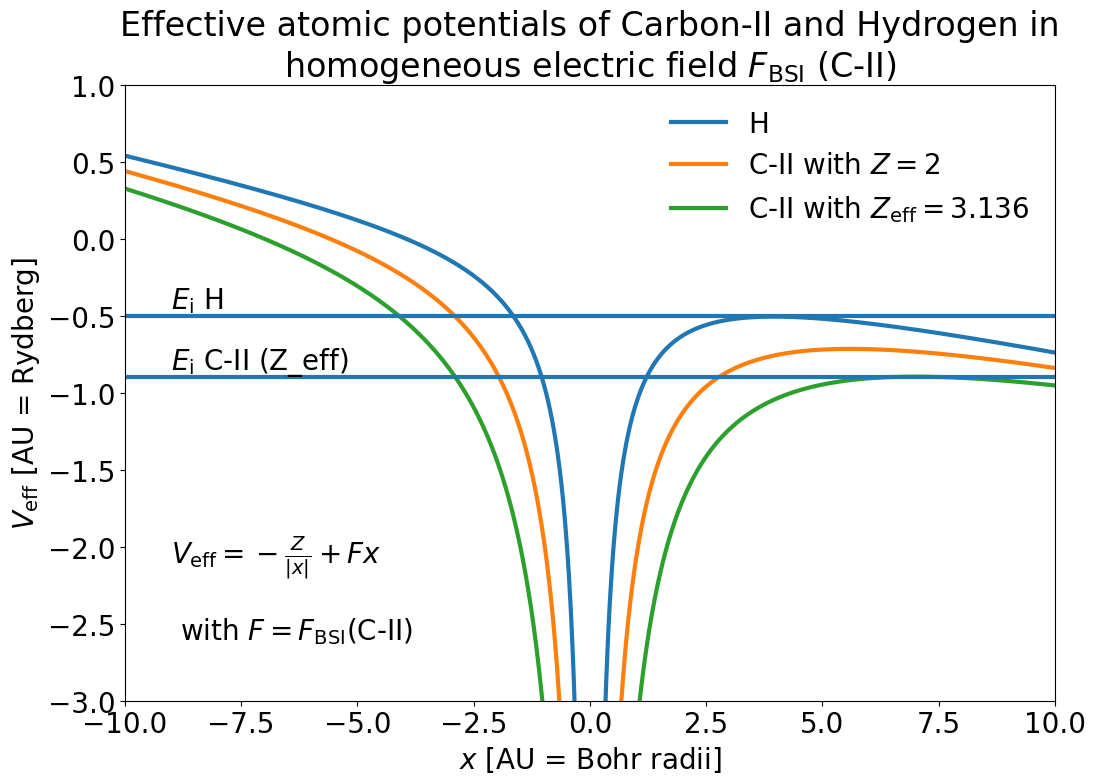

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np


params = {
    'font.size': 20,
    'lines.linewidth': 3,
    'legend.fontsize': 20,
    'legend.frameon': False,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    # RTD default textwidth: 800px
    'figure.figsize': [12, 8]
}
mpl.rcParams.update(params)


def V_eff(x, Z_eff, F):
    """
    Effective radially symmetric nuclear potential under the influence of a
    homogeneous external electric field. Assumed center of potential well
    at x = 0.

    Args:
        x       : spatial coordinate
        Z_eff   : effective residual ion charge
        F       : electric field strength

    Unit:
        1 AU = 27.2 eV
    """
    E_pot = -Z_eff / np.abs(x) + F * x
    return E_pot


if __name__ == "__main__":
    """
    On execution this script produces the image
    `field_ionization_effective_potentials.svg`
    for the PIConGPU documentation.
    """

    # for C-II from Clementi et al
    Z_C_eff = 3.136
    # for C-II naively from Z-N_eb, where N_eb denotes number of
    # bound electrons after ionization
    Z_C_naive = 2.0
    # Hydrogen nuclear charge
    Z_H = 1.0

    xmin = -10
    xmax = 10

    E_AU = 27.2  # atomic unit of energy
    E_CII = 24.36 / E_AU
    E_H = 13.6 / E_AU

    # barrier suppression field strength of CII
    F_BSI_CII = E_CII**2 / (4*Z_C_eff)

    r = np.linspace(xmin, xmax, 1000)  # spatial dimension

    V_H = V_eff(r, Z_H, -F_BSI_CII)
    V_CII_naive = V_eff(r, Z_C_naive, -F_BSI_CII)
    V_CII_eff = V_eff(r, Z_C_eff, -F_BSI_CII)

    # create the figure
    plt.figure()

    # plot the effective potentials
    plt.plot(r, V_H, label="H")
    plt.plot(r, V_CII_naive, label=r"C-II with $Z = 2$")
    plt.plot(r, V_CII_eff, label=r"C-II with $Z_\mathrm{eff} = 3.136$")

    # plot the ionization energies
    plt.hlines(-E_H, xmin, xmax)
    plt.hlines(-E_CII, xmin, xmax)

    # add the legend and format the plot
    plt.title("Effective atomic potentials of Carbon-II and Hydrogen in\n"
              r"homogeneous electric field $F_\mathrm{BSI}$ (C-II)")
    plt.legend(loc="best")
    plt.text(xmin+1, -E_H+.05, r"$E_\mathrm{i}$ H")
    plt.text(xmin+1, -E_CII+.05, r"$E_\mathrm{i}$ C-II (Z_eff)")
    plt.text(xmin+1, -2.1, r"$V_\mathrm{eff} = -\frac{Z}{|x|} + Fx$")
    plt.text(xmin+1, -2.6, r"$\mathrm{\ with\ } F = F_\mathrm{BSI}$(C-II)")
    plt.xlim([-10., 10.])
    plt.ylim([-3., 1.])
    plt.ylabel(r"$V_\mathrm{eff}$ [AU = Rydberg]")
    plt.xlabel(r"$x$ [AU = Bohr radii]")

    plt.show()


In [7]:
"""
Ionization prediction module and example.

This file is part of the PIConGPU.
Copyright 2019-2020 PIConGPU contributors
Authors: Marco Garten
License: GPLv3+
"""

import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
from importlib import import_module

"""
picongpu_package_path = os.path.abspath('C:/Users/medina/Documents/Git/PYCE_sw/picongpu/')

if picongpu_package_path not in sys.path:
    sys.path.insert(0, picongpu_package_path)


# import my own modules without having to write a 'noqa' comment because PEP8
# requires all imports to be at the top of the file
FI_module = import_module(name='.utils.field_ionization', package='picongpu')
"""

# Get the path to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "C:/Users/medina/Documents/Git/PYCE_sw/picongpu/"))
sys.path.insert(0, parent_dir)

# Now import your module
from field_ionization import FieldIonization
FI = FieldIonization()


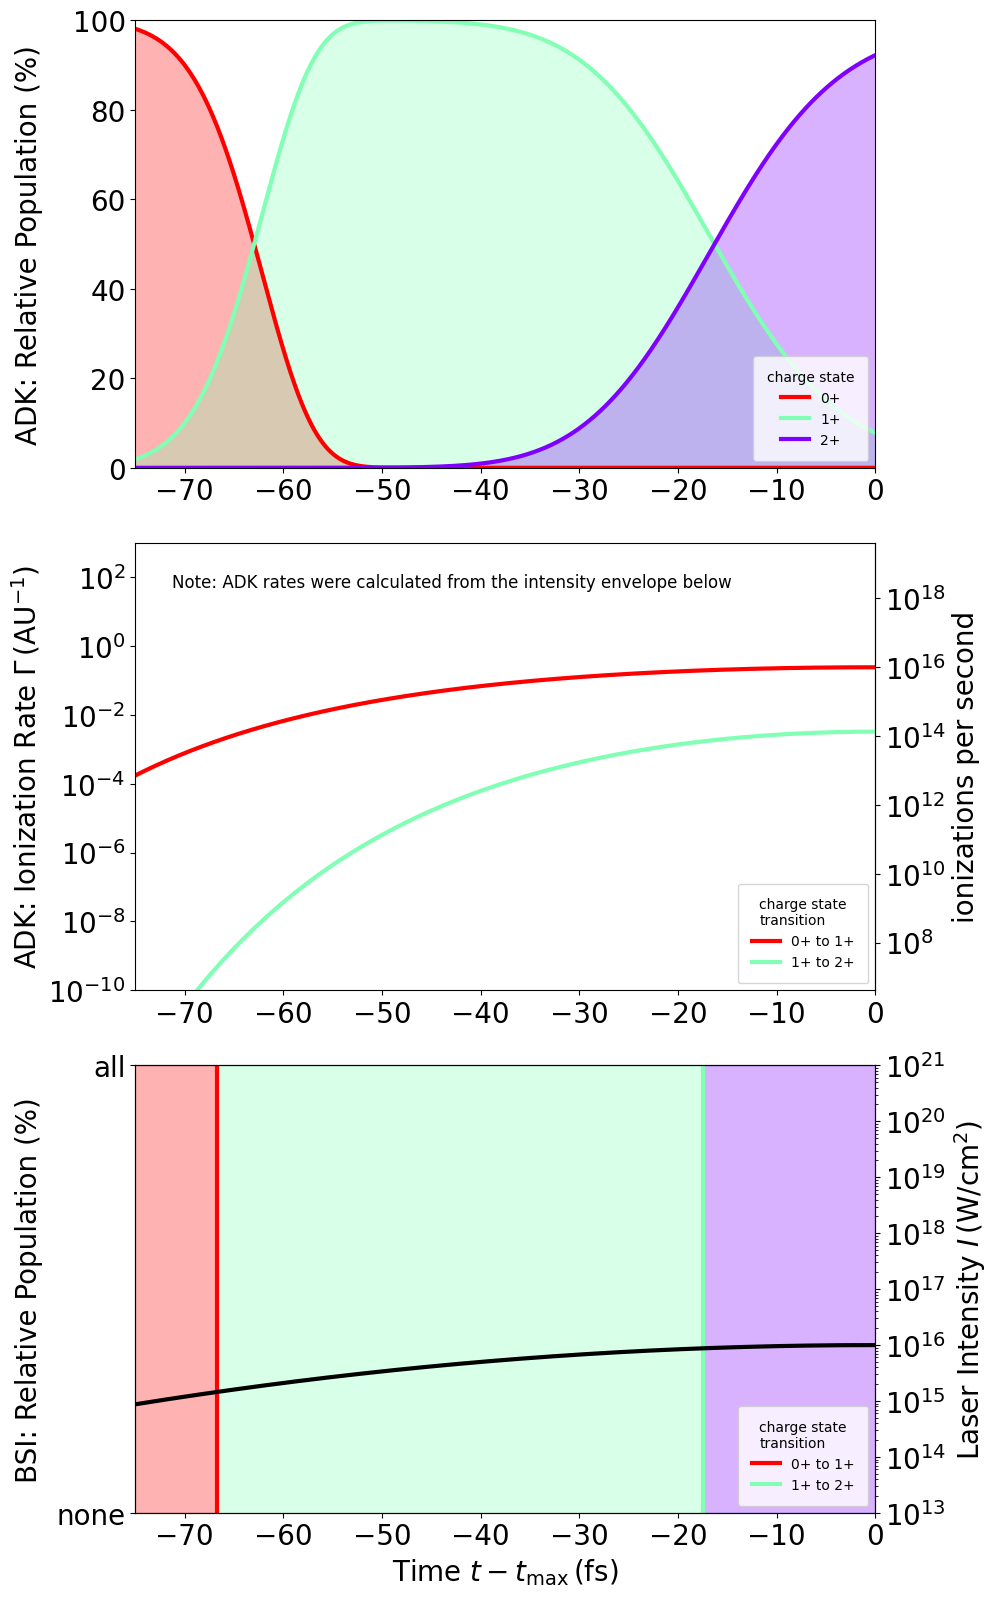

In [33]:

params = {
    'font.size': 20,
    'lines.linewidth': 3,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    # RTD default textwidth: 800px
    'figure.figsize': [10, 16],
    'legend.title_fontsize': 10
}
mpl.rcParams.update(params)


def time_AU_to_SI(t_AU):
    """Convert time from AU to SI.

    :param t_AU: time in atomic units

    :returns: time in SI units
    """
    return t_AU * AU_T


def time_SI_to_AU(t_SI):
    """Convert time from SI to AU.

    :param t_SI: time in SI units

    :returns: time in atomic units
    """
    return t_SI / AU_T


if __name__ == "__main__":
    """
    On execution, this file produces the image
    `field_ionization_charge_state_prediction.svg`
    for the PIConGPU documentation.
    """
    # instantiate FieldIonization classobject
    #FI = FI_module.FieldIonization()
    AU = FI.atomic_unit

    # atomic units
    AU_E_eV = AU['energy'] / sc.electron_volt  # eV
    AU_F = AU['electric field']  # V/m
    AU_I = AU['intensity']  # W/m^2
    AU_T = AU['time']  # s

    # proton number: Neon
    Z_max = 2
    # array of ionized charge states: Neon
    Z = np.arange(1, Z_max + 1, dtype=int)
    # array of ionization energies in eV for Neon
    # taken from https://physics.nist.gov/cgi-bin/ASD/ie.pl
    ionization_energies_eV = np.array([
        24.57,
        54.41
    ])

    # convert ionization energies to atomic units
    i_pot_AU = ionization_energies_eV / AU_E_eV

    # for population conversion
    percent = 1e-2
    # femtosecond: for time conversion
    fs = 1e-15
    # cm^2 in m^2
    cm2 = 1e-4

# ============================================================================
#   Create the electric field distribution for our example.
# ============================================================================
    # laser wavelength [unit: m]
    lambda_laser = 800.e-9
    # maximum electric field in a0
    E_max_a0 = 3.32e-8 #Correspond to 10^14 W/cm-1
    # maximum intensity
    I_max = FI.convert_a0_to_Intensity(E_in_a0=E_max_a0)  # W/m^2
    I_max= 1*10e19

    """ Or get the Max elec fiel E_max from the intensity
    I_max_SI = 5*10**14  # Desired intensity in W/m^2
    # Calculate electric field from intensity (SI units)
    E_max_SI = np.sqrt(2 * I_max_SI / (c * epsilon_0))
    """
    
    intensity_fwhm = 80.e-15  # s
    intensity_sigma = intensity_fwhm / (2. * np.sqrt(2. * np.log(2)))  # s

    # the sampling resolution here determines how smooth the transitions
    # in the Markov chain are
    t_res = 10000
    time = np.linspace(-200e-15, 200e-15, t_res)  # s
    intensity_envelope_SI = I_max * np.exp(- .5 * time**2 / intensity_sigma**2)

    intensity_envelope_AU = intensity_envelope_SI / AU_I
    e_field_envelope_AU = np.sqrt(intensity_envelope_AU)

# =============================================================================
#   Calculate the ADK rates for the electric field envelope and each charge
#   state.
# =============================================================================
    rate_matrix = np.zeros([len(i_pot_AU), t_res])

    for i, cs in enumerate(Z):
        rate_matrix[i, :] = FI.ADKRate(cs, i_pot_AU[i], e_field_envelope_AU)


# =============================================================================
#   Markovian approach for calculating the transition matrices of the problem.
# =============================================================================

    # transition matrix
    trans_mat_base = np.diag(np.ones([Z_max + 1]))
    trans_mat_before = trans_mat_base
    # preparation of the transition matrix: Markov absorbing state CS = 10
    trans_mat_base[Z_max, Z_max] = 1

    # prepare initial state
    initState = np.zeros([Z_max + 1])
    # all atoms are initially unionized
    initState[0] = 1

    # prepare expected charge distribution array
    charge_dist = np.zeros([Z_max + 1, t_res + 1])
    # manipulate last entry for loop
    charge_dist[:, -1] = initState

    # time step of the Markov process
    dt = (time[-1] - time[0]) / AU_T / t_res

    # loop over steps
    for i in np.arange(t_res):
        # calculate the transition matrix of this step
        trans_mat = trans_mat_base
        for k, cs in enumerate(Z):
            # probability to stay bound
            trans_mat[k, k] = np.exp(-rate_matrix[k, i] * dt)
            # probability to ionize
            trans_mat[k + 1, k] = 1. - np.exp(-rate_matrix[k, i] * dt)

        # Markov step
        charge_dist[:, i] = np.dot(charge_dist[:, i - 1], trans_mat.T)


# =============================================================================
#   Barrier suppression field strength calculation
# =============================================================================
    electric_field_BSI = FI.F_crit_BSI(Z, i_pot_AU)

    # find times when BSI fields are exceeded
    time_BSI = np.zeros([Z_max])
    for i, cs in enumerate(Z):
        idx = np.where(e_field_envelope_AU > electric_field_BSI[i])[0][0]
        time_BSI[i] = time[idx - 1]


# =============================================================================
#   Plotting the ionization rates, the electric field and the charge state
#   population over time.
# =============================================================================
    xlim = [-75, -0]
    ylim_ax_rate = [1e-10, 1e3]  # 1 / AU of time
    ylim_ax_pop = [0, 100]
    ylim_ax_bsi = [0, 100]
    ylim_ax_bsi_twin = [1e13, 1e21]  # W/cm^2
    yfill_range = np.linspace(ylim_ax_bsi[0], ylim_ax_bsi[1], 100)

    # customize the color scale
    color = plt.cm.rainbow(np.linspace(0, 1, Z_max + 1))[::-1]

    # creation of figure and axes
    fig = plt.figure()

    ax_rate = fig.add_subplot(312)
    ax_pop = fig.add_subplot(311, sharex=ax_rate)
    ax_bsi = fig.add_subplot(313, sharex=ax_rate)

    for i in np.arange(Z_max + 1):
        if i < Z_max:
            ax_rate.plot(
                time / fs, rate_matrix[i, :],
                label="{}+ to {}+".format(
                    Z[i] - 1, Z[i]), color=color[i]
            )
            ax_bsi.axvline(
                time_BSI[i] / fs,
                label="{}+ to {}+".format(
                    Z[i] - 1, Z[i]), color=color[i]
            )

        ax_pop.plot(
            time / fs, charge_dist[i, :-1] / percent,
            label="{}+".format(i), color=color[i]
        )
        ax_pop.fill_between(
            x=time / fs,
            y1=0, y2=charge_dist[i, :-1] / percent,
            color=color[i], alpha=.3
        )
        # color the regions between charge state transitions in the BSI model
        if (i > 0 and i < Z_max):
            ax_bsi.fill_betweenx(
                y=yfill_range,
                x1=time_BSI[i - 1] / fs,
                x2=time_BSI[i] / fs,
                color=color[i],
                alpha=.3
            )
        # color the range between the earliest time and the first charge state
        # transition
        if (i == 0):
            ax_bsi.fill_betweenx(
                y=yfill_range,
                x1=time[0] / fs,
                x2=time_BSI[i] / fs,
                color=color[i],
                alpha=.3
            )
        # color the range between the last charge state transition and the
        # latest time
        if (i == Z_max):
            ax_bsi.fill_betweenx(
                y=yfill_range,
                x1=time_BSI[i - 1] / fs,
                x2=time[-1] / fs,
                color=color[i],
                alpha=.3
            )

    ax_bsi_twin = ax_bsi.twinx()
    # plot intensity in W/cm^2
    ax_bsi_twin.plot(time / fs, intensity_envelope_SI / 1e4, c="k")

    locs = np.array([0, 100])
    labels = ["none", "all"]
    ax_bsi.set_yticks(locs)
    ax_bsi.set_yticklabels(labels)

    # secondy y-axis for rate plot
    secaxy_rate = ax_rate.secondary_yaxis(
        'right',
        functions=(time_SI_to_AU, time_AU_to_SI)
    )
    secaxy_rate.set_ylabel(r'ionizations per second')

    # set plot limits
    ax_rate.set_xlim(xlim)
    ax_rate.set_yscale("log")
    ax_rate.set_ylim(ylim_ax_rate)
    ax_pop.set_ylim(ylim_ax_pop)
    ax_bsi.set_ylim(ylim_ax_bsi)
    ax_bsi_twin.set_yscale("log")
    ax_bsi_twin.set_ylim(ylim_ax_bsi_twin)

    # note string for ADK rate plot note
    note_string = "Note: ADK rates were calculated from the " \
        + "intensity envelope below"
    # note in ADK rate plot
    ax_rate.text(
        x=0.05,
        y=0.9,
        s=note_string,
        fontsize=12,
        transform=ax_rate.transAxes
    )

    # labels
    ax_rate.set_ylabel(r"ADK: Ionization Rate $\Gamma\,\mathrm{(AU^{-1})}$")
    ax_pop.set_ylabel(r"ADK: Relative Population (%)")
    ax_bsi_twin.set_ylabel(r"Laser Intensity $I\,\mathrm{(W/cm^2)}$")
    ax_bsi.set_xlabel(r"Time $t-t_\mathrm{max}\,\mathrm{(fs)}$")
    ax_bsi.set_ylabel(r"BSI: Relative Population (%)")

    ax_rate.legend(loc="lower right", fancybox=True, borderpad=1,
                   title="charge state"+"\n"+"transition")
    ax_pop.legend(loc="lower right", fancybox=True, borderpad=1,
                  title="charge state")
    ax_bsi.legend(loc="lower right", fancybox=True, borderpad=1,
                  title="charge state"+"\n"+"transition")

    fig.align_labels()
    plt.tight_layout(pad=0.4)

    plt.show()
